In [1]:
import metalearning_benchmarks.line_sine1d_benchmark
import torch
import wandb
from diffusion import DiffusionNeuralProcess
from diffu_vi_np_train_val import train_and_validate
from diffusion import DDS
from matplotlib import pyplot as plt
from metalearning_benchmarks.line_sine1d_benchmark import LineSine1D
from neural_process import NeuralProcess
from utils import (Config, DataConfig, DataModule, MetaLearningDataset,
                   ModelConfig, TrainValConfig, split_context_target)
from visualize import visualize_batch_1d

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
data_config = DataConfig(
    benchmark="LineSine1D",
    n_task=4096,
    n_datapoints_per_task=64,
    output_noise=0.1,
    seed_task=1237, 
    seed_x=123, 
    seed_noise=1237
)

model_config = ModelConfig(
    x_dim=1,
    y_dim=1,
    r_dim=2,
    z_dim=2,
    h_dim=128,
    num_layers_det_enc=4,
    num_layers_lat_enc=4,
    num_layers_dec=2,
    non_linearity="Tanh",
    is_attentive=False,
    has_latent_path=True,
    has_deterministic_path=False
)

train_val_config = TrainValConfig(
    batch_size=128,
    num_epochs=200,
    learning_rate=3e-4,
    split=(0.8, 0.2)
)

config = Config(
    data_config=data_config,
    model_config=model_config,
    train_val_config=train_val_config
)

In [4]:
benchmark = getattr(metalearning_benchmarks.line_sine1d_benchmark, config.data_config.benchmark)(
    n_task=config.data_config.n_task,
    n_datapoints_per_task=config.data_config.n_datapoints_per_task,
    output_noise=config.data_config.output_noise,
    seed_task=config.data_config.seed_task, 
    seed_x=config.data_config.seed_x, 
    seed_noise=config.data_config.seed_noise,
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=config.train_val_config.batch_size,
    dataset_and_split=(dataset, config.train_val_config.split),
    num_workers=15
)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 291500.43it/s]


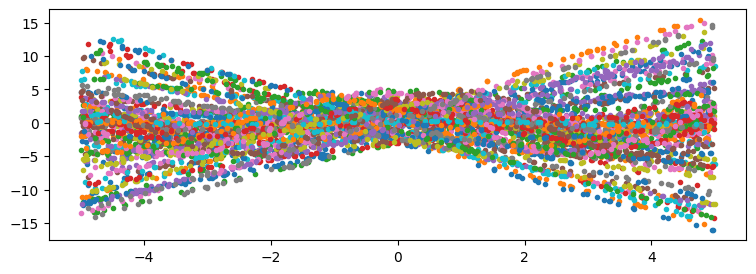

In [5]:
visualize_batch_1d(batch=next(iter(data_module.train_dataloader())))

In [6]:
np_model = NeuralProcess(**config.model_config.asdict()).to(device)
diffu_model = DDS(device=device, num_steps=32, z_dim=2, h_dim=64, beta_start=0.0001, beta_end=0.02, std_0=torch.tensor(1.0)).to(device)
diffu_vi_np_model = DiffusionNeuralProcess(np_model, diffu_model).to(device)

optimizer = torch.optim.Adam(diffu_vi_np_model.parameters(), lr=config.train_val_config.learning_rate)

In [7]:
wandb_logging = True
if wandb_logging:
    wandb.init(project="diffu-vi-np", config=config.asdict())

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [8]:
avg_train_log_likes = []
avg_train_diffu_loss = []

avg_val_log_likes = []
avg_val_diffu_loss = []

In [9]:
losses = train_and_validate(
    diffu_vi_np_model=diffu_vi_np_model,
    data_module=data_module,
    num_epochs=config.train_val_config.num_epochs,
    device=device,
    optimizer=optimizer,
    wandb_logging=wandb_logging,
)

avg_train_log_likes.extend(losses[0])
avg_train_diffu_loss.extend(losses[1])

avg_val_log_likes.extend(losses[2])
avg_val_diffu_loss.extend(losses[3])

  0%|          | 0/26 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
 62%|██████▏   | 16/26 [00:13<00:08,  1.20it/s, diffu_loss=-2.88e+3, epoch=56, log_like=-172, loss=3.05e+3]


KeyboardInterrupt: 

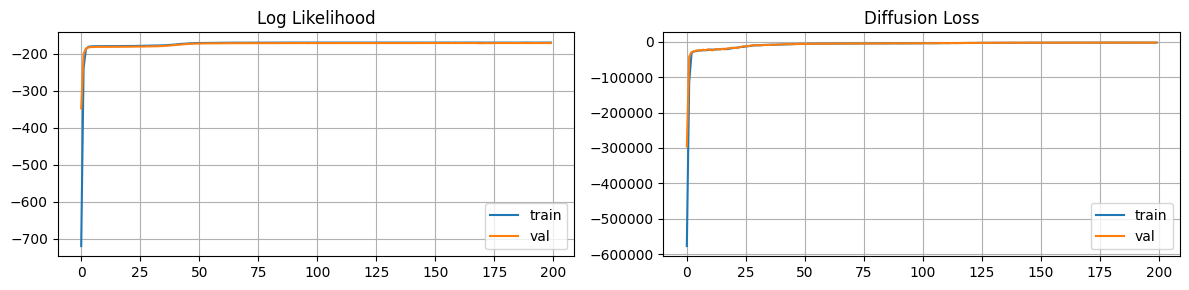

In [11]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(avg_train_log_likes, label="train")
ax[0].plot(avg_val_log_likes, label="val")
ax[0].set_title("Log Likelihood")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_diffu_loss, label="train")
ax[1].plot(avg_val_diffu_loss, label="val")
ax[1].set_title("Diffusion Loss")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [20]:
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)
x_data, y_data = next(iter(gen_dataloader))
x_data = x_data.to(device)
y_data = y_data.to(device)

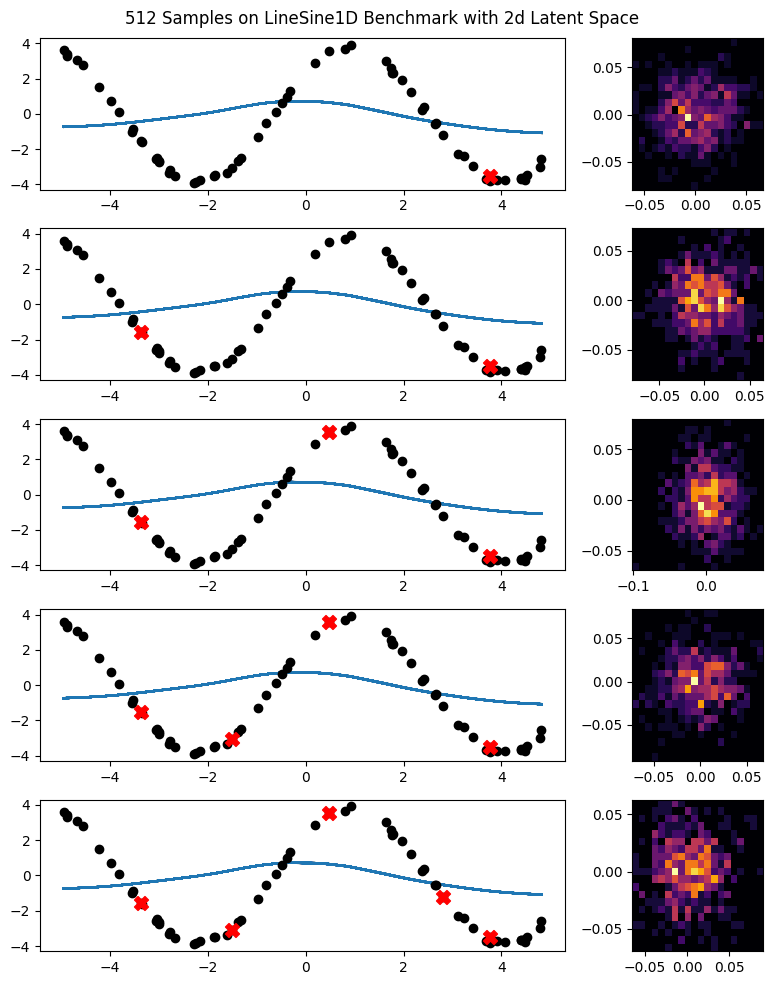

In [24]:
context_lens = [1, 2, 3, 4, 5] # x_data.shape[1] - 1

n_samples = 512

fig, ax  = plt.subplots(len(context_lens), 2, figsize=(8, 2 * len(context_lens)), gridspec_kw={'width_ratios': [4, 1]})
fig.suptitle(f"{n_samples} Samples on {config.data_config.benchmark} Benchmark with 2d Latent Space")

for i, context_len in enumerate(context_lens):

    x_context, y_context, _, _ = split_context_target(x_data, y_data, context_len=context_len, random=False)
    
    diffu_vi_np_model.eval()
    with torch.no_grad():
        
        _, y_mu, _, z, _, _ = diffu_vi_np_model.sample(x_context, y_context, x_data, n_samples)

        x_data_sorted, indices = x_data.sort(dim=1)
        indices = indices.squeeze(0).squeeze(1)
        x_data_sorted = x_data_sorted.cpu().detach().numpy()
        y_data_sorted = y_data[:, indices, :].cpu().detach().numpy()
        y_mu_sorted = y_mu[:, indices, :].cpu().detach().numpy()

        for k in range(n_samples):
            ax[i][0].plot(x_data_sorted.squeeze(0).squeeze(1), y_mu_sorted[k].squeeze(1), alpha=0.2, c="tab:blue", zorder=0)

        ax[i][0].scatter(x_data_sorted, y_data_sorted, marker="o", c="black", zorder=1)
        ax[i][0].scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="X", c="red", s=100, zorder=2)

        ax[i][1].hist2d(z[:, 0].cpu().detach().numpy(), z[:, 1].cpu().detach().numpy(), bins=20, cmap="inferno")
        
        # ax[i][1].set_xlim(-10, 10)
        # ax[i][1].set_ylim(-10, 10)
        # if i != 0:
        #     ax[i][1].sharex(ax[0][1])
        #     ax[i][1].sharey(ax[0][1])


plt.tight_layout()
plt.show()